In [3]:
import os
import random
import pandas as pd
import numpy as np
import mne
from matplotlib import pyplot as plt
from scipy import signal


%matplotlib inline

In [32]:
DATASET_PATH = r'C:\Users\juro\uni\01\zaklady_programovania\semestralna_praca\seizure_detection\seizure_detection\seizure_detection\scripts\data\datasets'
DATASET_SEIZURE_TEST = os.path.join(DATASET_PATH, 'test', 'seizure')
DATASET_SEIZURE_TRAIN = os.path.join(DATASET_PATH, 'train', 'seizure')
DATASET_NOT_SEIZURE_TEST = os.path.join(DATASET_PATH, 'test', 'not_seizure')
DATASET_NOT_SEIZURE_TRAIN = os.path.join(DATASET_PATH, 'train', 'not_seizure')

fs = 173.61

In [20]:
def load_data(file_path, output=False):
    data = pd.read_csv(file_path, dtype=float)
    if output:
        print(data.info())
        print(display(data.head()))
    return data

In [21]:
random_not_seizure_file = random.choice(os.listdir(DATASET_NOT_SEIZURE_TRAIN))
random_seizure_file = random.choice(os.listdir(DATASET_SEIZURE_TRAIN))
random_not_seizure_sample = load_data(os.path.join(DATASET_NOT_SEIZURE_TRAIN, random_not_seizure_file), output=True)
random_seizure_sample = load_data(os.path.join(DATASET_SEIZURE_TRAIN, random_seizure_file), output=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4096 entries, 0 to 4095
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   63      4096 non-null   float64
dtypes: float64(1)
memory usage: 32.1 KB
None


63
0  43.0
1  47.0
2  53.0
3  70.0
4  87.0

None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4096 entries, 0 to 4095
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   98      4096 non-null   float64
dtypes: float64(1)
memory usage: 32.1 KB
None


98
0  88.0
1  76.0
2  59.0
3  40.0
4  17.0

None


In [22]:
channel_name= ['CZ']
channel_type = ['eeg']
sample_rate = 173.61 # in hz

# create an mne info file with meta data about the EEG
info = mne.create_info(ch_names=channel_name, sfreq=sample_rate, 
                       ch_types=channel_type)

# show the info file
display(info)

<Info | 7 non-empty values
 bads: []
 ch_names: CZ
 chs: 1 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 86.8 Hz
 meas_date: unspecified
 nchan: 1
 projs: []
 sfreq: 173.6 Hz
>

In [23]:
def mne_object(data, info):
    data = data.apply(lambda x: x*1e-6)
    # transpose the data
    data_T = data.transpose()
    # create raw mne object
    raw = mne.io.RawArray(data_T, info)
    
    return raw

random_not_seizure = mne_object(random_not_seizure_sample, info)
random_seizure = mne_object(random_seizure_sample, info)

Creating RawArray with float64 data, n_channels=1, n_times=4096
    Range : 0 ... 4095 =      0.000 ...    23.587 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=4096
    Range : 0 ... 4095 =      0.000 ...    23.587 secs
Ready.


Setting up band-pass filter from 0.53 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.53, 40.00 Hz: -6.02, -6.02 dB



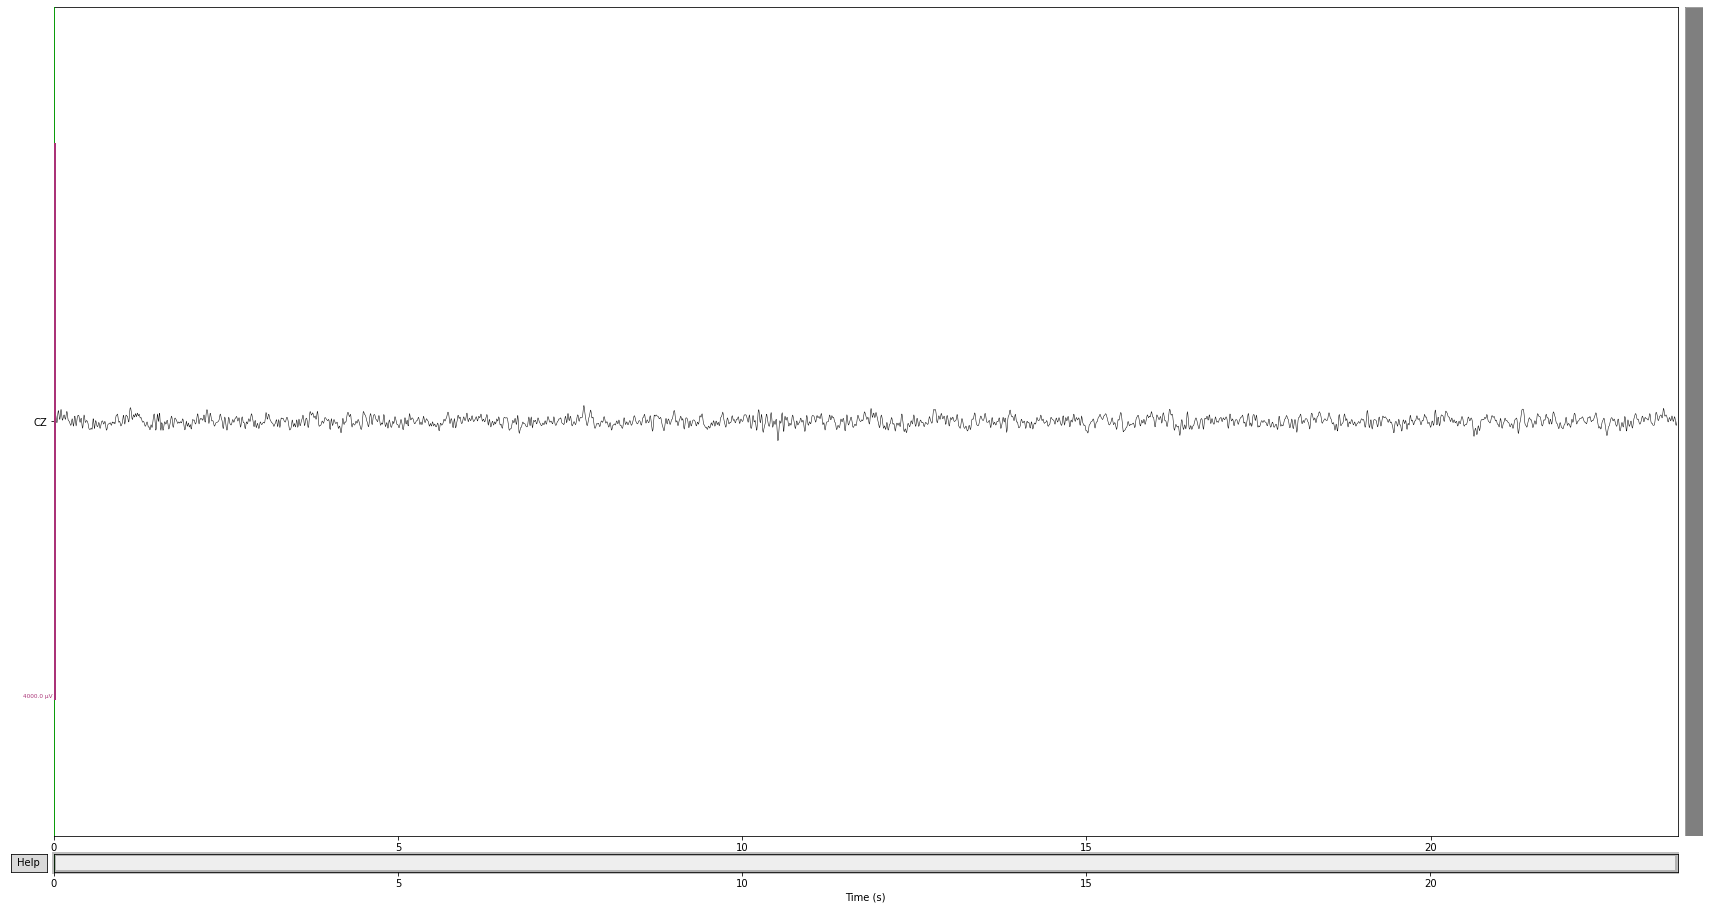

Setting up band-pass filter from 0.53 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.53, 40.00 Hz: -6.02, -6.02 dB



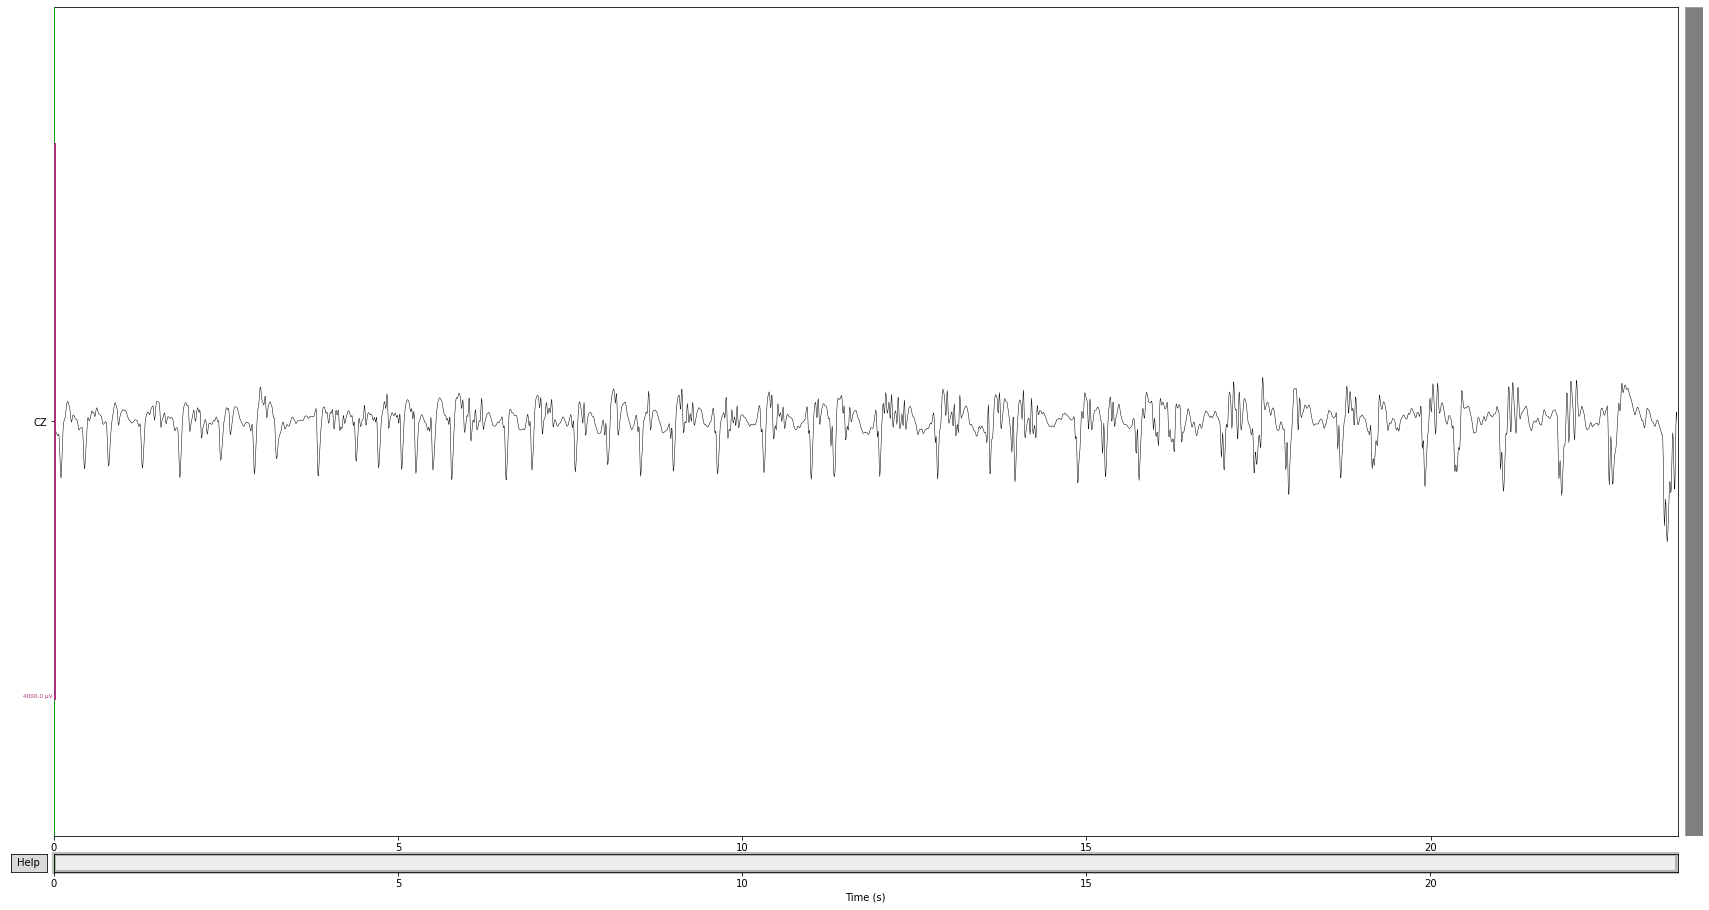

In [24]:

plot_kwargs = {
    'scalings': dict(eeg=20e-4),   # zooms the plot out
    'highpass': 0.53,              # filters out low frequencies
    'lowpass': 40.,                # filters out high frequencies
    'n_channels': 1,               # just plot the one channel
    'duration': 24                 # number of seconds to plot
}

random_not_seizure.plot(**plot_kwargs)
random_seizure.plot(**plot_kwargs);

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 287 samples (1.653 sec)

<Info | 7 non-empty values
 bads: []
 ch_names: CZ
 chs: 1 EEG
 custom_ref_applied: False
 highpass: 4.0 Hz
 lowpass: 30.0 Hz
 meas_date: unspecified
 nchan: 1
 projs: []
 sfreq: 173.6 Hz
>


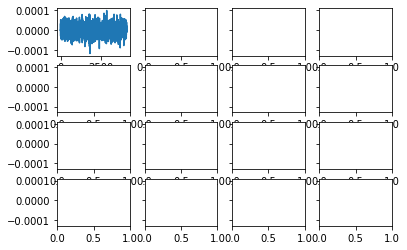

In [25]:
# just testing something
random_not_seizure.filter(4, 30)
print(random_not_seizure.info)
data = random_not_seizure.get_data()
fig, axs = plt.subplots(4, 4, sharey=True)
axs[0, 0].plot(data[0])
plt.show()

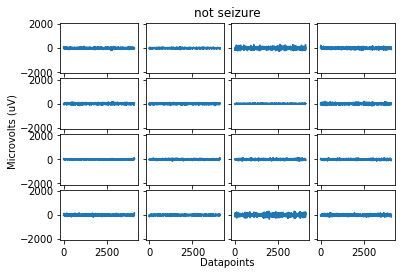

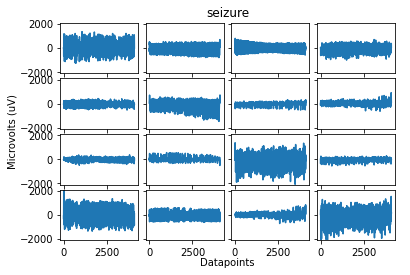

In [26]:
for set_path in [DATASET_NOT_SEIZURE_TRAIN, DATASET_SEIZURE_TRAIN]:
    files = os.listdir(set_path)
    # randomly select 9 files from the list
    sampled_files = random.sample(files, 16)
    fig, axs = plt.subplots(4, 4, sharey=True)
    x=0
    y=0
    for file in sampled_files:

        data = load_data(os.path.join(set_path, file))
        b, a = signal.butter(4, [1/(sample_rate/2), 30/(sample_rate/2)], 'bandpass', analog=False)
        filt_data = signal.filtfilt(b, a, data.T).T

        axs[x, y].plot(filt_data)
        # plot all of them on the same scale
        axs[x, y].set_ylim([-2100, 2100])

        x+=1

        if x == 4:
            y +=1
            x=0

    # add a big axes, hide frame
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axes
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.xlabel("Datapoints", labelpad =0.5)
    plt.ylabel("Microvolts (uV)", labelpad =20)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)    
    if set_path == DATASET_NOT_SEIZURE_TRAIN:
        plt.title('not seizure')
    else:
        plt.title('seizure')

    plt.show()

# average signal

Text(0.5, 0, 'Time')

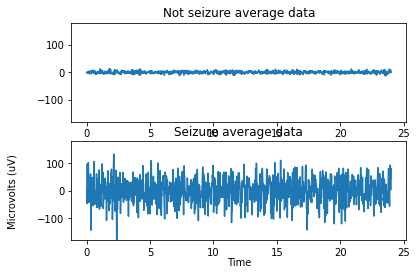

In [27]:
fig, axs = plt.subplots(2)

not_seizure_data = []
for file in os.listdir(DATASET_NOT_SEIZURE_TRAIN):
    data = load_data(os.path.join(DATASET_NOT_SEIZURE_TRAIN, file)).to_numpy()
    b, a = signal.butter(4, [1/(sample_rate/2), 30/(sample_rate/2)], 'bandpass', analog=False)
    filt_data = signal.filtfilt(b, a, data.T)
    not_seizure_data.append(filt_data)
not_seizure_data = np.array(not_seizure_data)
average_train = np.mean(not_seizure_data, axis=0)
axs[0].plot(np.linspace(0, 24, average_train.shape[-1]), average_train[0])
axs[0].set_ylim([-180, 180])
axs[0].set_title("Not seizure average data")


seizure_data = []
for file in os.listdir(DATASET_SEIZURE_TRAIN):
    data = load_data(os.path.join(DATASET_SEIZURE_TRAIN, file)).to_numpy()
    b, a = signal.butter(4, [1/(sample_rate/2), 30/(sample_rate/2)], 'bandpass', analog=False)
    filt_data = signal.filtfilt(b, a, data.T)
    seizure_data.append(filt_data)
seizure_data = np.array(seizure_data)
average_train = np.mean(seizure_data, axis=0)
axs[1].plot(np.linspace(0, 24, average_train.shape[-1]), average_train[0])
axs[1].set_ylim([-180, 180])
axs[1].set_title("Seizure average data")

plt.ylabel("Microvolts (uV)", labelpad =20)
plt.xlabel("Time", labelpad =0.5)

# FFT analysis

In [28]:
#Fast Fourier transform
def fft(data, fs):
    L = len(data)
    freq = np.linspace(0.0, 1.0 / (2.0 * fs **-1), L // 2)
    yi = np.fft.fft(data)[1:]
    y = yi[range(int(L / 2))]
    return freq, abs(y)

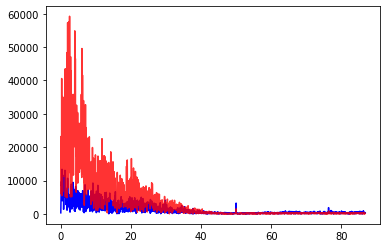

In [47]:

not_seizure = random_not_seizure_sample.values.T
freq1, t1 = fft(not_seizure[0], fs)
plt.plot(freq1, t1, color='b')

seizure = random_seizure_sample.values.T
freq2, t2 = fft(seizure[0], fs)
plt.plot(freq2, t2, color='r', alpha=0.8)